<a href="https://colab.research.google.com/github/sahupra1357/LLMAgents/blob/main/Groq_LLamaFunctionCalling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')

In [ ]:
!pip install langchain_groq -q
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.2 MB/s eta 0:00:00


In [ ]:
from langchain_groq import ChatGroq
import os
import yfinance as yf
import pandas as pd

In [ ]:
GROQ_API_KEY = os.environ["GROQ_API_KEY"]
llm = ChatGroq(groq_api_key = GROQ_API_KEY,model = 'llama-3.3-70b-versatile')

In [ ]:
from langchain_core.tools import tool

@tool
def get_stock_info(symbol, key):
    '''Return the correct stock info value given the appropriate symbol and key. Infer valid key from the user prompt; it must be one of the following:

    address1, city, state, zip, country, phone, website, industry, industryKey, industryDisp, sector, sectorKey, sectorDisp, longBusinessSummary, fullTimeEmployees, companyOfficers, auditRisk, boardRisk, compensationRisk, shareHolderRightsRisk, overallRisk, governanceEpochDate, compensationAsOfEpochDate, maxAge, priceHint, previousClose, open, dayLow, dayHigh, regularMarketPreviousClose, regularMarketOpen, regularMarketDayLow, regularMarketDayHigh, dividendRate, dividendYield, exDividendDate, beta, trailingPE, forwardPE, volume, regularMarketVolume, averageVolume, averageVolume10days, averageDailyVolume10Day, bid, ask, bidSize, askSize, marketCap, fiftyTwoWeekLow, fiftyTwoWeekHigh, priceToSalesTrailing12Months, fiftyDayAverage, twoHundredDayAverage, currency, enterpriseValue, profitMargins, floatShares, sharesOutstanding, sharesShort, sharesShortPriorMonth, sharesShortPreviousMonthDate, dateShortInterest, sharesPercentSharesOut, heldPercentInsiders, heldPercentInstitutions, shortRatio, shortPercentOfFloat, impliedSharesOutstanding, bookValue, priceToBook, lastFiscalYearEnd, nextFiscalYearEnd, mostRecentQuarter, earningsQuarterlyGrowth, netIncomeToCommon, trailingEps, forwardEps, pegRatio, enterpriseToRevenue, enterpriseToEbitda, 52WeekChange, SandP52WeekChange, lastDividendValue, lastDividendDate, exchange, quoteType, symbol, underlyingSymbol, shortName, longName, firstTradeDateEpochUtc, timeZoneFullName, timeZoneShortName, uuid, messageBoardId, gmtOffSetMilliseconds, currentPrice, targetHighPrice, targetLowPrice, targetMeanPrice, targetMedianPrice, recommendationMean, recommendationKey, numberOfAnalystOpinions, totalCash, totalCashPerShare, ebitda, totalDebt, quickRatio, currentRatio, totalRevenue, debtToEquity, revenuePerShare, returnOnAssets, returnOnEquity, freeCashflow, operatingCashflow, earningsGrowth, revenueGrowth, grossMargins, ebitdaMargins, operatingMargins, financialCurrency, trailingPegRatio

    If asked generically for 'stock price', use currentPrice
    '''
    data = yf.Ticker(symbol)
    stock_info = data.info
    return stock_info[key]


@tool
def get_historical_price(symbol, start_date, end_date):
    """
    Fetches historical stock prices for a given symbol from 'start_date' to 'end_date'.
    - symbol (str): Stock ticker symbol.
    - end_date (date): Typically today unless a specific end date is provided. End date MUST be greater than start date
    - start_date (date): Set explicitly, or calculated as 'end_date - date interval' (for example, if prompted 'over the past 6 months', date interval = 6 months so start_date would be 6 months earlier than today's date). Default to '1900-01-01' if vaguely asked for historical price. Start date must always be before the current date
    """

    data = yf.Ticker(symbol)
    hist = data.history(start=start_date, end=end_date)
    print(hist)
    hist = hist.reset_index()
    hist[symbol] = hist['Close']
    return hist[['Date', symbol]]

In [ ]:
tools = [get_stock_info, get_historical_price]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
query1 = 'What is the market cap of Meta?'
query2 = 'How does the volume of Apple compare to that of Microsoft?'

print(llm_with_tools.invoke(query1).tool_calls)
print(llm_with_tools.invoke(query2).tool_calls)

[{'name': 'get_stock_info', 'args': {'symbol': 'META', 'key': 'marketCap'}, 'id': 'call_a54z', 'type': 'tool_call'}]
[{'name': 'get_stock_info', 'args': {'symbol': 'AAPL', 'key': 'volume'}, 'id': 'call_bszw', 'type': 'tool_call'}, {'name': 'get_stock_info', 'args': {'symbol': 'MSFT', 'key': 'volume'}, 'id': 'call_tjde', 'type': 'tool_call'}]


In [ ]:
query1 = 'Show the historical price of the S&P 500 over the past 3 years? (Today is 4/23/2024)'
query2 = 'Compare the price of Google and Amazon throughout 2023'

print(llm_with_tools.invoke(query1).tool_calls)
print(llm_with_tools.invoke(query2).tool_calls)

[{'name': 'get_historical_price', 'args': {'symbol': '^GSPC', 'start_date': '2021-04-23', 'end_date': '2024-04-23'}, 'id': 'call_9rf7', 'type': 'tool_call'}]
[{'name': 'get_historical_price', 'args': {'symbol': 'GOOG', 'start_date': '2023-01-01', 'end_date': '2023-12-31'}, 'id': 'call_521c', 'type': 'tool_call'}, {'name': 'get_historical_price', 'args': {'symbol': 'AMZN', 'start_date': '2023-01-01', 'end_date': '2023-12-31'}, 'id': 'call_yrnf', 'type': 'tool_call'}]


In [ ]:
import pandas as pd
import plotly.graph_objects as go

def plot_price_over_time(historical_price_dfs):

    full_df = pd.DataFrame(columns = ['Date'])
    for df in historical_price_dfs:
        full_df = full_df.merge(df, on = 'Date', how = 'outer')

    # Create a Plotly figure
    fig = go.Figure()

    # Dynamically add a trace for each stock symbol in the DataFrame
    for column in full_df.columns[1:]:  # Skip the first column since it's the date
        fig.add_trace(go.Scatter(x=full_df['Date'], y=full_df[column], mode='lines+markers', name=column))


    # Update the layout to add titles and format axis labels
    fig.update_layout(
        title='Stock Price Over Time: ' + ', '.join(full_df.columns.tolist()[1:]),
        xaxis_title='Date',
        yaxis_title='Stock Price (USD)',
        yaxis_tickprefix='$',
        yaxis_tickformat=',.2f',
        xaxis=dict(
            tickangle=-45,
            nticks=20,
            tickfont=dict(size=10),
        ),
        yaxis=dict(
            showgrid=True,   # Enable y-axis grid lines
            gridcolor='lightgrey',  # Set grid line color
        ),
        legend_title_text='Stock Symbol',
        plot_bgcolor='white',  # Set plot background to white
        paper_bgcolor='white',  # Set overall figure background to white
        legend=dict(
            bgcolor='white',  # Optional: Set legend background to white
            bordercolor='black'
        )
    )

    # Show the figure - unfortunately dynamic charts are not supported on GitHub preview, so this just generates
    # a static .png. If running locally, you can use fig.show(renderer='iframe') to output a dynamic plotly plot
    fig.show('png')

In [ ]:
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, ToolMessage
from datetime import date

def call_functions(llm_with_tools, user_prompt):
    system_prompt = 'You are a helpful finance assistant that analyzes stocks and stock prices. Today is {today}'.format(today = date.today())

    messages = [SystemMessage(system_prompt), HumanMessage(user_prompt)]
    ai_msg = llm_with_tools.invoke(messages)
    messages.append(ai_msg)
    historical_price_dfs = []
    symbols = []
    for tool_call in ai_msg.tool_calls:
        selected_tool = {"get_stock_info": get_stock_info, "get_historical_price": get_historical_price}[tool_call["name"].lower()]
        tool_output = selected_tool.invoke(tool_call["args"])
        if tool_call['name'] == 'get_historical_price':
            historical_price_dfs.append(tool_output)
            symbols.append(tool_output.columns[1])
        else:
            messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))

    if len(historical_price_dfs) > 0:
        plot_price_over_time(historical_price_dfs)
        symbols = ' and '.join(symbols)
        messages.append(ToolMessage('Tell the user that a historical stock price chart for {symbols} been generated.'.format(symbols=symbols), tool_call_id=0))

    print("messages --> ", messages)
    return llm_with_tools.invoke(messages).content

In [ ]:
user_prompt = 'What is the beta for meta stock?'
call_functions(llm_with_tools, user_prompt)

messages -->  [SystemMessage(content='You are a helpful finance assistant that analyzes stocks and stock prices. Today is 2025-03-30', additional_kwargs={}, response_metadata={}), HumanMessage(content='What is the beta for meta stock?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_22wp', 'function': {'arguments': '{"symbol": "META", "key": "beta"}', 'name': 'get_stock_info'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 1595, 'total_tokens': 1616, 'completion_time': 0.076363636, 'prompt_time': 0.11033532, 'queue_time': 0.24300204399999997, 'total_time': 0.186698956}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_41c250edc7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b09f73ee-0001-45dd-a78f-9f6bcd618ca3-0', tool_calls=[{'name': 'get_stock_info', 'args': {'symbol': 'META', 'key': 'beta'}, 'id': 'call_22wp', 'type': 'tool_call'}],

'The beta for Meta stock is 1.231.'

                                 Open        High         Low       Close  \
Date                                                                        
2024-09-30 00:00:00-04:00  164.405968  166.980113  164.266286  166.810501   
2024-10-01 00:00:00-04:00  168.476708  170.053124  165.523420  168.037704   
2024-10-02 00:00:00-04:00  167.379197  168.496665  165.872630  166.930222   
2024-10-03 00:00:00-04:00  165.443615  167.528868  164.994625  166.830460   
2024-10-04 00:00:00-04:00  168.955612  169.165142  166.581024  168.177383   
...                               ...         ...         ...         ...   
2025-03-24 00:00:00-04:00  169.264999  170.500000  167.440002  169.929993   
2025-03-25 00:00:00-04:00  171.179993  172.910004  170.550003  172.789993   
2025-03-26 00:00:00-04:00  171.300003  171.940002  166.860992  167.139999   
2025-03-27 00:00:00-04:00  166.710007  167.440002  163.850006  164.080002   
2025-03-28 00:00:00-04:00  162.360001  163.809998  155.339005  156.059998   

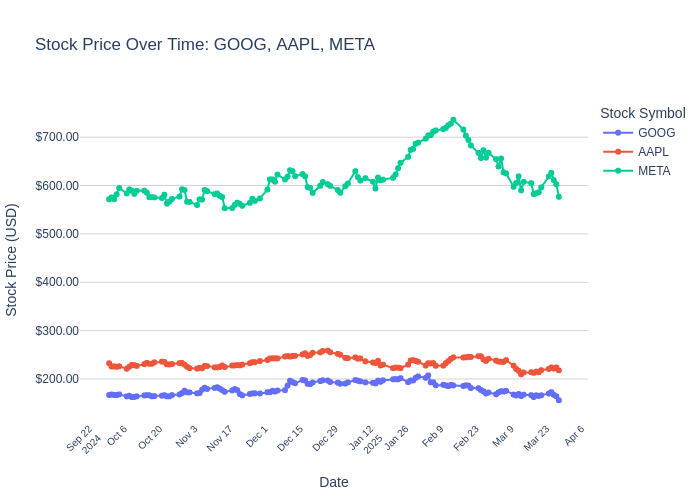

messages -->  [SystemMessage(content='You are a helpful finance assistant that analyzes stocks and stock prices. Today is 2025-03-30', additional_kwargs={}, response_metadata={}), HumanMessage(content='Compare the stock price of Google, Apple and Meta over the past 6 months', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4mvz', 'function': {'arguments': '{"symbol": "GOOG", "start_date": "2024-09-30", "end_date": "2025-03-30"}', 'name': 'get_historical_price'}, 'type': 'function'}, {'id': 'call_xjmf', 'function': {'arguments': '{"symbol": "AAPL", "start_date": "2024-09-30", "end_date": "2025-03-30"}', 'name': 'get_historical_price'}, 'type': 'function'}, {'id': 'call_vvc8', 'function': {'arguments': '{"symbol": "META", "start_date": "2024-09-30", "end_date": "2025-03-30"}', 'name': 'get_historical_price'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 120, 'prompt_tokens': 1603, 'total_t

'A historical stock price chart for GOOG, AAPL, and META has been generated, showing the stock prices over the past 6 months.'

In [ ]:
user_prompt = "Compare the stock price of Google, Apple and Meta over the past 6 months"
call_functions(llm_with_tools, user_prompt)